In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def zeta_derivs(lambdify=False):
    """
    Generates an expression for Z position of
    cosine hill of height h, with a baseline
    at z_b. Thengets functions evaluating derivatives
    of zeta with respect to x and z. Uses a linear
    warping of the z dimension to map the surface
    z_s to the  midpoint of the vertical iteration
    space.
    
    Returns
    -------
    zeta_xz : function or SymPy expression
        Zeta with respect to x and z
    zeta_dx : function or SymPy expression
        First derivative of zeta with respect to x
    zeta_dz : function or SymPy expression
        First derivative of zeta with respect to z
    zeta_dx2 : function or SymPy expression
        Second derivative of zeta with respect to x
    zeta_dz2 : function or SymPy expression
        Second derivative of zeta with respect to z
    z_zeta : function or SymPy expression
        Z with respect to zeta
    z_s : function or Sympy expression
        Z position of the surface with respect to x
    """
    # Get the cosine hill expression
    x, h, xM, xm, zb = sp.symbols('x, h, x_max, x_min, z_b')
    cos_centre = zb + h/2
    w = xM-xm  # Wavelength
    zs = cos_centre - h*sp.cos(2*sp.pi*(x-xm)/w)/2
    
    # Create the variable-z warp
    sym_names = """zeta_min, zeta_max, zeta, z_min, z"""
    zetam, zetaM, zeta, zm, z = sp.symbols(sym_names)

    A = sp.Matrix([[1, zm],
                   [1, zs]])

    b = sp.Matrix([[zetam],
                   [zetaM/2]])

    sol = A**-1*b
    
    # Form the function
    poly = sol[0] + sol[1]*z
    
    funcs = []
    
    if lambdify:
        params = [x, z, xM, xm, zb, zm, zetaM, zetam, h]
        funcs.append(sp.lambdify(params, poly))  # No derivs taken
        for i in range(1, 3):  # Derivs
            funcs.append(sp.lambdify(params, sp.diff(poly, x, i)))
            funcs.append(sp.lambdify(params, sp.diff(poly, z, i)))
    else:
        funcs.append(poly)  # No derivs taken
        for i in range(1, 3):  # Derivs
            funcs.append(sp.diff(poly, x, i))
            funcs.append(sp.diff(poly, z, i))

    # Inverse
    C = sp.Matrix([[1, zetam],
                   [1, zetaM/2]])
    d = sp.Matrix([[zm],
                   [zs]])
    
    solinv = C**-1*d
    polyinv = solinv[0] + solinv[1]*zeta
    
    if lambdify:
        paramsinv = [x, zeta, xM, xm, zb, zm, zetaM, zetam, h]
        funcs.append(sp.lambdify(paramsinv, polyinv))
    else:
        funcs.append(polyinv)
        
    # Function of the surface
    if lambdify:
        paramssurf = [x, xM, xm, zb, h]
        funcs.append(sp.lambdify(paramssurf, zs))
    else:
        funcs.append(zs)

    funcs = tuple(funcs)
    return funcs

zeta_xz, zeta_dx1, zeta_dz1, zeta_dx2, zeta_dz2, z_xzeta, z_s = zeta_derivs(lambdify=True)

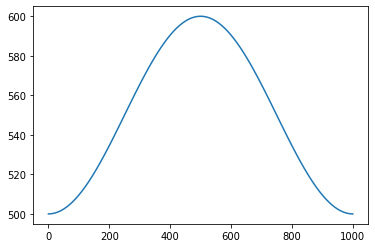

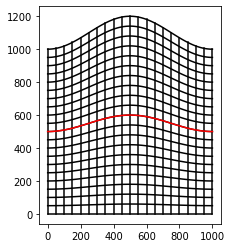

In [2]:
from devito import SpaceDimension, Grid, Function

# Grid parameterisation
x_m = 0
x_M = 1000  # Units of metres
z_m = 0
z_b = 500
z_M = 1000
zeta_m = 0
zeta_M = 1

h = 100  # Height of topography

x = SpaceDimension(name='x')
zeta = SpaceDimension(name='zeta')

grid = Grid(shape=(101, 101), extent=(x_M-x_m, zeta_M-zeta_m),
            origin=(x_m, zeta_m), dimensions=(x, zeta))

# Get surface profile
x_vals = np.linspace(x_m, x_M, grid.shape[0])
zeta_vals = np.linspace(zeta_m, zeta_M, grid.shape[1])
surface_z = z_s(x_vals, x_M, x_m, z_b, h)
plt.plot(x_vals, surface_z)
plt.show()

# Derivatives of zeta can be precalculated
# dzeta/dz is constant wrt z (only needs dimensions of y)
# dzeta2/dz2 is thus zero
zeta_dz = Function(name='zeta_dz', shape=(grid.shape[0],),
                   extent=(grid.extent[0],), origin=(x_m,),
                   dimensions=(x,))

# Z doesn't really matter here, so set to baseline value
zeta_dz.data[:] = zeta_dz1(x_vals, z_b, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

# Make an x-zeta meshgrid (for precalculating values)
x_msh, zeta_msh = np.meshgrid(x_vals, zeta_vals)

# Z mesh for plotting and evaluating derivs
z_msh = z_xzeta(x_msh, zeta_msh, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

# dzeta/dx
zeta_dx = Function(name='zeta_dx', grid=grid)
# Transpose makes meshgrid match Devito indexing convention
zeta_dx.data[:] = zeta_dx1(x_msh.T, z_msh.T, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)

# dzeta2/dx2
zeta_dxx = Function(name='zeta_dxx', grid=grid)
zeta_dxx.data[:] = zeta_dx2(x_msh.T, z_msh.T, x_M, x_m, z_b, z_m, zeta_M, zeta_m, h)


# Make a plot showing zeta horizons in x-z space
cells = 20
plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
# Plot the x lines
plt.plot(x_msh[:, ::grid.shape[0]//cells], z_msh[:, ::grid.shape[1]//cells], 'k')
# Plot the zeta horizons
plt.plot(x_msh.T[:, ::grid.shape[0]//cells], z_msh.T[:, ::grid.shape[1]//cells], 'k')
# Pick out the central horizon
plt.plot(x_vals, z_xzeta(x_vals, (zeta_M-zeta_m)/2, x_M, x_m,
                         z_b, z_m, zeta_M, zeta_m, h), 'r')
plt.show()

In [3]:
from devito import TimeFunction, Eq

# Wavespeed
c = 2

# Set up the function and equations
p = TimeFunction(name="p", grid=grid, time_order=2, space_order=8)
# Modified derivative expressions (note these are not the shortcuts)
pdx2 = p.dx2+p.dx.dzeta*zeta_dx+(p.dx.dzeta+p.dzeta2*zeta_dx)*zeta_dx+p.dzeta*zeta_dxx
pdz2 = p.dzeta2*zeta_dz**2

eq = Eq(p.forward, 2*p - p.backward + c**2*(pdx2 + pdz2))

In [4]:
# Create the free surface
def freesurface(f):
    """
    Implements an acoustic free-surface boundary at
    the centre index.
    
    Parameters
    ----------
    f : TimeFunction
        The function on which the boundary condition
        is imposed.
    """
    t = grid.stepping_dim
    
    # Midpoint index
    mid_ind = (f.grid.shape[1]-1)//2
    bcs = [Eq(f[t+1,x, mid_ind], 0)]
    for i in range(f.space_order//2):
        bcs += [Eq(f[t+1,x, mid_ind+i+1], -f[t+1,x, mid_ind-i-1])]
    return bcs


bcs = freesurface(p)

In [5]:
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts a t=0
tn = 500.  # Simulation last 1 second (1000 ms)
dt = grid.extent[0]/(2*c*(grid.shape[0]-1))  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(grid.extent)/2  # Centre first
src.coordinates.data[0, -1] = grid.extent[1]/3  # Set depth

src_term = src.inject(field=p.forward, expr=src*dt**2/c)

In [6]:
from devito import Operator

op = Operator([eq] + bcs + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.008717000000000013, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=6.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

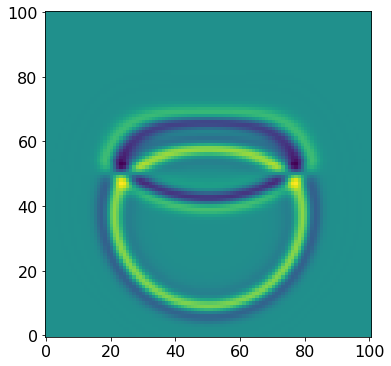

In [7]:
plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.imshow(p.data[-1].T, origin='lower')
plt.show()

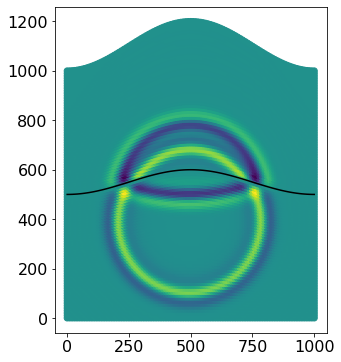

In [8]:
plt.figure()
ax = plt.gca()
ax.set_aspect('equal')
plt.scatter(x_msh, z_msh, c=p.data[-1].T, cmap='viridis')
# Pick out the central horizon
plt.plot(x_vals, z_xzeta(x_vals, (zeta_M-zeta_m)/2, x_M, x_m,
                         z_b, z_m, zeta_M, zeta_m, h), 'k')
plt.show()

In [9]:
# TODO: Add a subdomain to make tidier
# TODO: Package things up neatly